**Tutorial Outline**
1. Importing the dependencies
2. Loading the data
3. Exploratory data analysis
4. Data pre-processing
5. Collaborative filtering using K-Nearest Neighbors
6. Handeling the cold-start problem with content-based filtering
7. Dimensionality reduction with matrix factorization

## Step 1: Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Load Data

In [2]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')

In [3]:
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [4]:
ratings.head()  # Displays the first 5 rows of the 'ratings' DataFrame

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Step 3: Exploratory Data Analysis

In [6]:
n_ratings = len(ratings)  # Total number of ratings
n_movies = ratings['movieId'].nunique()  # Number of unique movies rated
n_users = ratings['userId'].nunique()  # Number of unique users who rated

# Output summary statistics
print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieIDs: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")  # Avg ratings per user
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")  # Avg ratings per movie

Number of ratings: 100836
Number of unique movieIDs: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


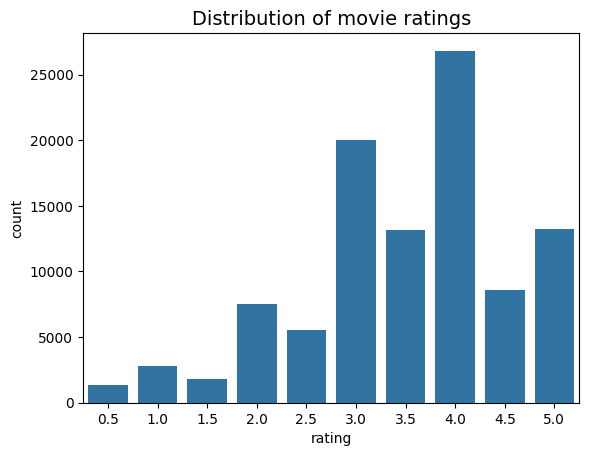

In [7]:
sns.countplot(x='rating', data=ratings)
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [8]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")# Calculates the average rating and rounds it to 2 decimal places

Mean global rating: 3.5.


In [9]:
mean_ratings = ratings.groupby('userId')['rating'].mean()  # Calculates the mean rating for each user
print(f"Mean rating per user: {round(mean_ratings.mean(), 2)}")  # Prints the average of users' mean ratings, rounded to 2 decimal places

Mean rating per user: 3.66


In [10]:
ratings['movieId'].value_counts()  # Returns the count of ratings for each movie, sorted in descending order

movieId
356       329
318       317
296       307
593       279
2571      278
         ... 
188833      1
189381      1
3899        1
2848        1
147002      1
Name: count, Length: 9724, dtype: int64

In [11]:
movie_ratings = ratings.merge(movies, on='movieId')  # Merges 'ratings' and 'movies' DataFrames on 'movieId'
movie_ratings['title'].value_counts()[0:10]  # Gets the 10 most rated movie titles

title
Forrest Gump (1994)                          329
Shawshank Redemption, The (1994)             317
Pulp Fiction (1994)                          307
Silence of the Lambs, The (1991)             279
Matrix, The (1999)                           278
Star Wars: Episode IV - A New Hope (1977)    251
Jurassic Park (1993)                         238
Braveheart (1995)                            237
Terminator 2: Judgment Day (1991)            224
Schindler's List (1993)                      220
Name: count, dtype: int64

**Lowest and highest rated movies**

In [12]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()  # Calculates the mean rating for each movie
lowest_rated = mean_ratings['rating'].idxmin()  # Finds the movieId of the lowest-rated movie
# mean_ratings  # (Optional) Displays the DataFrame of average ratings for each movie
movies[movies['movieId'] == lowest_rated]  # Retrieves the movie details of the lowest-rated movie

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [13]:
highest_rated = mean_ratings['rating'].idxmax()  # Finds the movieId of the highest-rated movie
movies[movies['movieId'] == highest_rated]  # Retrieves the movie details of the highest-rated movie

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [14]:
ratings[ratings['movieId'] == highest_rated]  # Retrieves all ratings for the highest-rated movie

,userId,movieId,rating,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


"Lamerica" might be the highest rated movie, but it only has 2 ratings. We'd better evaluate movie popularity by getting the [Bayesian average](https://en.wikipedia.org/wiki/Bayesian_average#:~:text=A%20Bayesian%20average%20is%20a,available%20data%20set%20is%20small.).

In [17]:
movie_stats = ratings.groupby('movieId')['rating'].agg(['count', 'mean'])  # Aggregates count and mean of ratings for each movie
movie_stats.head()  # Displays the first 5 rows of the 'movie_stats' DataFrame

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [20]:
C = movie_stats['count'].mean()  # Calculates the average number of ratings per movie
m = movie_stats['mean'].mean()  # Calculates the average rating across all movies

print(f"Avrage number of ratings for a given movie: {C: 2f}")
print(f"Avrage ratings for a given movie: {m: 2f}")

Avrage number of ratings for a given movie:  10.369807
Avrage ratings for a given movie:  3.262448


In [21]:
def bayesian_avg(ratings):  # Defines a function to calculate the Bayesian average rating
    bayesian_avg = (C*m + ratings.sum()) / (C + ratings.count())  # Computes the Bayesian average
    return round(bayesian_avg, 3)  # Returns the rounded Bayesian average to 3 decimal places

In [23]:
lamerica = pd.Series([5, 5])  # Creates a pandas Series with two ratings of 5
bayesian_avg(lamerica)  # Calls the 'bayesian_avg' function to calculate the Bayesian average for 'lamerica'

np.float64(3.543)